<a href="https://colab.research.google.com/github/econdatatech/AIML425/blob/main/AIML425_Assignement_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # AIML 425 Assignement 4
Corvin Idler - ID 300598312


# Preparation
First we install all the required packages and import all libraries we need. We set all the needed random seeds and check what version of Pytorch and hardware we have been given by Google Colab.

In [1]:
!pip install torchsummary --quiet
!pip install poutyne --quiet
!pip install livelossplot --quiet
!pip install torchmetrics --quiet


In [2]:
## Import Standard libraries
import os
import math
import numpy as np 
import time
import glob
from pathlib import Path
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 
from IPython.display import set_matplotlib_formats
from IPython.core.display import display,Image
from string import Template
from matplotlib.colors import to_rgba
plt.rcParams['figure.figsize'] = [10, 3]

#Import Torch stuff for data generation
import torch
from  torch.distributions.multivariate_normal import MultivariateNormal
import torch.utils.data as data
from torch.utils.data import random_split
from torchmetrics.functional import mean_squared_error
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchmetrics import Accuracy


#Import Torch stuff for estimation and evaluation
from torch.autograd import Variable
from torch.autograd.function import once_differentiable
from tqdm.notebook import tqdm
import torch.optim as optim  
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import imageio
from torchvision.utils import make_grid

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
import collections
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import tensorboard logger from PyTorch
from tensorboard import summary
from torch.utils.tensorboard import SummaryWriter
from tensorboard.plugins.custom_scalar import layout_pb2
from tensorboard.plugins.custom_scalar import summary as cs_summary
from livelossplot import PlotLossesPoutyne # This module talks with Poutyne
import poutyne
from poutyne.framework import Model 
from poutyne.framework import ModelCheckpoint 
from poutyne.framework import EarlyStopping

# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard

#Image generation stuff
from PIL import Image, ImageDraw

#Take care of randoms seeds at various places to ensure reproducability
# GPU operations have a separate seed we also want to set
SEED=42
np.random.seed(42)
torch.manual_seed(42) # Setting the seed
CUDA=torch.cuda.is_available()
if CUDA: 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Check PyTorch version and CUDA hardware from Google Colabs
print("Using torch", torch.__version__)
device = torch.device("cuda") if CUDA else torch.device("cpu")
!cat /proc/cpuinfo
print("Device", device)
!nvidia-smi



Using torch 1.12.1+cu113
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_ali

# Image generation
We generate images and save them in the temporary storage.

In [14]:
!mkdir images
!mkdir images/circle
!mkdir images/rectangle
!mkdir images/triangle

for i in range(16):
  for j in range(16):
    im = Image.new('L', (28, 28), (255))
    draw = ImageDraw.Draw(im)
    draw.ellipse([(0+i, 0+j),(12+i, 12+j)], fill=(0), outline=(0))
    im.save('images/circle/c'+str(i)+str(j)+'.bmp')

    im1 = Image.new('L', (28, 28), (255))
    draw = ImageDraw.Draw(im1)
    draw.rectangle([(0+i,0+j),(12+i,12+j)], fill =(0), outline =(0))
    im1.save('images/rectangle/r'+str(i)+str(j)+'.bmp')

    im2 = Image.new('L', (28, 28), (255))
    draw = ImageDraw.Draw(im2)
    draw.polygon([(6+i,0+j),(0+i,12+j),(12+i,12+j)], fill =(0), outline =(0))
    im2.save('images/triangle/t'+str(i)+str(j)+'.bmp')

mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘images/circle’: File exists
mkdir: cannot create directory ‘images/rectangle’: File exists
mkdir: cannot create directory ‘images/triangle’: File exists


Display all the images (TAKES A FAIR BIT OF TIME)

In [15]:
images = []
for path in Path('images').rglob('*.bmp'):
    images.append(mpimg.imread(path))


plt.figure(figsize=(200,200))
columns = 30
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

Count the images and check the dimensions

In [16]:
mydataset = ImageFolder(root="images/",transform =  transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()]))
idx = [Image.open(mydataset.imgs[i][0]).size for i in range(len(mydataset)) ]
df = pd.DataFrame.from_dict(collections.Counter(idx), orient='index').reset_index()
print(df)


      index    0
0  (28, 28)  750


Define the data loaders for training, validation and test set

In [17]:
batch_size = 64

num_train = len(mydataset)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_and_test_size = 0.3 
split1 = int(np.floor(valid_and_test_size * num_train))
split2 = int(np.floor(split1/3))
train_idx, valid_idx, test_idx = indices[split1:], indices[split2:split1], indices[:split2]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)


trainloader = DataLoader(mydataset, sampler=train_sampler, batch_size=batch_size, shuffle=False,pin_memory=True)
valloader = DataLoader(mydataset, sampler=valid_sampler, batch_size=len(valid_idx), shuffle=False,pin_memory=True)
testloader = DataLoader(mydataset, sampler=test_sampler, batch_size=len(test_idx), shuffle=False,pin_memory=True)
classes = ('circle', 'rectangle', 'triangle')

print('len(train_idx) ==> ', len(train_idx))
print('len(valid_idx) ==> ', len(valid_idx))
print('len(test_idx) ==> ', len(test_idx))

len(train_idx) ==>  525
len(valid_idx) ==>  150
len(test_idx) ==>  75


Check if the images in the test set are a good mix of all 3 geometric shapes.

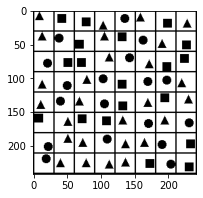

In [18]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:64]))




#Network generation, training and evaluation
loosely based on https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/

In [50]:
to_pil_image = transforms.ToPILImage()

def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('outputs/generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"outputs/output{epoch}.jpg")
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.jpg')
    plt.show()




In [20]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, dataloader, len_dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len_dataset/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

def validate(model, dataloader, len_dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len_dataset/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len_dataset/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images


In [98]:
kernel_size = 2 # (2, 2) kernel
init_channels = 6 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling

# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        self.encoder = nn.Sequential(
            nn.Conv2d(
              in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=1, padding = 1),
            nn.Mish(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(
              in_channels=init_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=1 , padding = 1),
            nn.Mish(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(294, 32)
        )
        
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_log_var = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 294),
            nn.Mish(),
            nn.Unflatten(-1,(6, 7, 7)),
            nn.ConvTranspose2d(
              in_channels=init_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2),
            nn.Mish(),
            nn.ConvTranspose2d(
            in_channels=init_channels, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2),
            nn.Sigmoid()
        )

  
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
    
    def bottleneck(self, h):
        mu, logvar = self.fc_mu(h), self.fc_log_var(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [99]:
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 250
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

#from torchsummary import summary

#summary(model=model, input_size=(1, 28, 28), batch_size=batch_size) # Summarize


In [100]:
!mkdir outputs

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, len(train_idx), device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, valloader, len(valid_idx), device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

mkdir: cannot create directory ‘outputs’: File exists
Epoch 1 of 250


9it [00:00, 18.07it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Train Loss: 39512.8582
Val Loss: 100905.3125
Epoch 2 of 250


9it [00:00, 18.26it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


Train Loss: 39068.3146
Val Loss: 99671.1562
Epoch 3 of 250


9it [00:00, 17.72it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


Train Loss: 38507.3167
Val Loss: 97853.7656
Epoch 4 of 250


9it [00:00, 18.04it/s]                       
100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


Train Loss: 37563.9841
Val Loss: 94100.1406
Epoch 5 of 250


9it [00:00, 17.80it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


Train Loss: 35722.8206
Val Loss: 87408.7266
Epoch 6 of 250


9it [00:00, 18.02it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Train Loss: 32766.9180
Val Loss: 78820.1484
Epoch 7 of 250


9it [00:00, 18.28it/s]                       
100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


Train Loss: 29381.3589
Val Loss: 70299.4453
Epoch 8 of 250


9it [00:00, 18.38it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


Train Loss: 26236.7979
Val Loss: 63193.8789
Epoch 9 of 250


9it [00:00, 18.57it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Train Loss: 23803.4793
Val Loss: 58209.1641
Epoch 10 of 250


9it [00:00, 18.40it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


Train Loss: 22058.0117
Val Loss: 54492.6445
Epoch 11 of 250


9it [00:00, 17.93it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


Train Loss: 20793.5569
Val Loss: 51786.9805
Epoch 12 of 250


9it [00:00, 17.54it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


Train Loss: 19787.6776
Val Loss: 49513.0000
Epoch 13 of 250


9it [00:00, 17.31it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


Train Loss: 18852.6325
Val Loss: 46935.8828
Epoch 14 of 250


9it [00:00, 16.87it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


Train Loss: 17803.5047
Val Loss: 44339.3320
Epoch 15 of 250


9it [00:00, 10.72it/s]                       
100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


Train Loss: 16809.8099
Val Loss: 41731.3125
Epoch 16 of 250


9it [00:00, 17.50it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Train Loss: 15964.1033
Val Loss: 39807.7969
Epoch 17 of 250


9it [00:00, 12.08it/s]                       
100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


Train Loss: 15132.4631
Val Loss: 37948.2422
Epoch 18 of 250


9it [00:00, 13.85it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


Train Loss: 14470.5775
Val Loss: 36568.1914
Epoch 19 of 250


9it [00:00, 17.09it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


Train Loss: 13905.7523
Val Loss: 35451.2383
Epoch 20 of 250


9it [00:00, 17.52it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


Train Loss: 13476.9844
Val Loss: 34193.4492
Epoch 21 of 250


9it [00:00, 16.78it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


Train Loss: 13166.8602
Val Loss: 33509.0469
Epoch 22 of 250


9it [00:00, 17.23it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


Train Loss: 12820.6804
Val Loss: 32837.1562
Epoch 23 of 250


9it [00:00, 17.53it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Train Loss: 12550.8639
Val Loss: 31826.3262
Epoch 24 of 250


9it [00:00, 17.04it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


Train Loss: 12275.3469
Val Loss: 31396.8691
Epoch 25 of 250


9it [00:00, 17.14it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


Train Loss: 12083.3614
Val Loss: 30815.1602
Epoch 26 of 250


9it [00:00, 17.63it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Train Loss: 11881.1148
Val Loss: 30176.0039
Epoch 27 of 250


9it [00:00, 17.55it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Train Loss: 11695.7220
Val Loss: 29765.9219
Epoch 28 of 250


9it [00:00, 16.97it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


Train Loss: 11492.4821
Val Loss: 29462.3242
Epoch 29 of 250


9it [00:00, 17.83it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


Train Loss: 11277.9451
Val Loss: 28854.8789
Epoch 30 of 250


9it [00:00, 17.56it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


Train Loss: 11137.4168
Val Loss: 28509.4121
Epoch 31 of 250


9it [00:00, 17.76it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


Train Loss: 10937.4217
Val Loss: 28205.5410
Epoch 32 of 250


9it [00:00, 17.51it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


Train Loss: 10753.6083
Val Loss: 27481.9648
Epoch 33 of 250


9it [00:00, 17.16it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Train Loss: 10562.1092
Val Loss: 26933.3203
Epoch 34 of 250


9it [00:00, 17.57it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


Train Loss: 10376.8061
Val Loss: 26425.5332
Epoch 35 of 250


9it [00:00, 17.80it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Train Loss: 10170.1705
Val Loss: 26166.6191
Epoch 36 of 250


9it [00:00, 17.50it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


Train Loss: 10065.9854
Val Loss: 25882.8594
Epoch 37 of 250


9it [00:00, 17.64it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


Train Loss: 9895.4804
Val Loss: 25501.8281
Epoch 38 of 250


9it [00:00, 17.25it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Train Loss: 9802.8668
Val Loss: 25053.4922
Epoch 39 of 250


9it [00:00, 17.58it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


Train Loss: 9683.8652
Val Loss: 24842.1934
Epoch 40 of 250


9it [00:00, 18.04it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Train Loss: 9551.0595
Val Loss: 24487.0293
Epoch 41 of 250


9it [00:00, 17.81it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Train Loss: 9438.3291
Val Loss: 24463.8809
Epoch 42 of 250


9it [00:00, 17.38it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


Train Loss: 9337.3950
Val Loss: 24201.1875
Epoch 43 of 250


9it [00:00, 18.05it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


Train Loss: 9203.7979
Val Loss: 23826.7070
Epoch 44 of 250


9it [00:00, 17.56it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


Train Loss: 9147.6094
Val Loss: 23600.8965
Epoch 45 of 250


9it [00:00, 18.02it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Train Loss: 9008.0435
Val Loss: 23346.0352
Epoch 46 of 250


9it [00:00, 17.82it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Train Loss: 8955.9307
Val Loss: 23309.0566
Epoch 47 of 250


9it [00:00, 17.94it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


Train Loss: 8859.7462
Val Loss: 23027.9863
Epoch 48 of 250


9it [00:00, 17.48it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Train Loss: 8780.8035
Val Loss: 22850.5039
Epoch 49 of 250


9it [00:00, 17.62it/s]                       
100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


Train Loss: 8675.7172
Val Loss: 22280.5879
Epoch 50 of 250


9it [00:00, 17.63it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


Train Loss: 8591.3153
Val Loss: 22300.5840
Epoch 51 of 250


9it [00:00, 17.92it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


Train Loss: 8501.7528
Val Loss: 22027.8613
Epoch 52 of 250


9it [00:00, 17.81it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Train Loss: 8419.6437
Val Loss: 21676.5430
Epoch 53 of 250


9it [00:00, 17.64it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


Train Loss: 8327.2582
Val Loss: 21697.2168
Epoch 54 of 250


9it [00:00, 17.52it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Train Loss: 8313.7782
Val Loss: 21403.2988
Epoch 55 of 250


9it [00:00, 17.63it/s]                       
100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


Train Loss: 8178.0734
Val Loss: 21142.7500
Epoch 56 of 250


9it [00:00, 17.75it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Train Loss: 8102.3399
Val Loss: 20940.6914
Epoch 57 of 250


9it [00:00, 17.59it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


Train Loss: 7987.8756
Val Loss: 20662.9199
Epoch 58 of 250


9it [00:00, 17.44it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


Train Loss: 7965.8200
Val Loss: 20599.5898
Epoch 59 of 250


9it [00:00, 17.82it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


Train Loss: 7858.6189
Val Loss: 20409.4492
Epoch 60 of 250


9it [00:00, 17.39it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


Train Loss: 7775.5737
Val Loss: 20001.7305
Epoch 61 of 250


9it [00:00, 17.64it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Train Loss: 7713.0388
Val Loss: 20028.1582
Epoch 62 of 250


9it [00:00, 17.42it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


Train Loss: 7653.0701
Val Loss: 19682.4043
Epoch 63 of 250


9it [00:00, 17.49it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Train Loss: 7588.7114
Val Loss: 19537.3105
Epoch 64 of 250


9it [00:00, 17.95it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


Train Loss: 7498.1754
Val Loss: 19384.8750
Epoch 65 of 250


9it [00:00, 17.95it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


Train Loss: 7429.4297
Val Loss: 19229.8086
Epoch 66 of 250


9it [00:00, 17.68it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Train Loss: 7345.7593
Val Loss: 19203.2676
Epoch 67 of 250


9it [00:00, 17.74it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Train Loss: 7328.2119
Val Loss: 19134.5508
Epoch 68 of 250


9it [00:00, 18.12it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


Train Loss: 7278.4707
Val Loss: 18700.1953
Epoch 69 of 250


9it [00:00, 18.13it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


Train Loss: 7185.9061
Val Loss: 18533.7246
Epoch 70 of 250


9it [00:00, 17.90it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Train Loss: 7151.8964
Val Loss: 18496.7852
Epoch 71 of 250


9it [00:00, 10.43it/s]
100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


Train Loss: 7096.7823
Val Loss: 18162.4531
Epoch 72 of 250


9it [00:00, 17.35it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


Train Loss: 7020.3380
Val Loss: 18151.3262
Epoch 73 of 250


9it [00:00, 17.95it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


Train Loss: 6988.8582
Val Loss: 17935.8301
Epoch 74 of 250


9it [00:00, 17.82it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


Train Loss: 6925.7884
Val Loss: 17902.7793
Epoch 75 of 250


9it [00:00, 17.49it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


Train Loss: 6866.6992
Val Loss: 17627.7891
Epoch 76 of 250


9it [00:00, 18.24it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Train Loss: 6803.9343
Val Loss: 17641.5195
Epoch 77 of 250


9it [00:00, 17.95it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


Train Loss: 6772.7603
Val Loss: 17507.0000
Epoch 78 of 250


9it [00:00, 17.92it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Train Loss: 6709.0920
Val Loss: 17314.2148
Epoch 79 of 250


9it [00:00, 18.15it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


Train Loss: 6670.4099
Val Loss: 17347.1348
Epoch 80 of 250


9it [00:00, 17.67it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


Train Loss: 6655.1249
Val Loss: 17086.5527
Epoch 81 of 250


9it [00:00, 17.08it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Train Loss: 6539.2477
Val Loss: 17025.8516
Epoch 82 of 250


9it [00:00, 18.08it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Train Loss: 6569.0013
Val Loss: 17116.7109
Epoch 83 of 250


9it [00:00, 17.48it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


Train Loss: 6539.1355
Val Loss: 17079.9727
Epoch 84 of 250


9it [00:00, 17.67it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


Train Loss: 6512.1437
Val Loss: 16995.6777
Epoch 85 of 250


9it [00:00, 18.20it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Train Loss: 6490.5938
Val Loss: 16583.3320
Epoch 86 of 250


9it [00:00, 17.75it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Train Loss: 6394.6417
Val Loss: 16792.4160
Epoch 87 of 250


9it [00:00, 18.30it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


Train Loss: 6405.1487
Val Loss: 16650.3652
Epoch 88 of 250


9it [00:00, 17.84it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Train Loss: 6316.5216
Val Loss: 16643.7598
Epoch 89 of 250


9it [00:00, 17.69it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


Train Loss: 6324.5283
Val Loss: 16397.4648
Epoch 90 of 250


9it [00:00, 17.99it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


Train Loss: 6280.8911
Val Loss: 16192.9717
Epoch 91 of 250


9it [00:00, 18.06it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


Train Loss: 6272.2593
Val Loss: 16365.8164
Epoch 92 of 250


9it [00:00, 17.52it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


Train Loss: 6211.5153
Val Loss: 15972.8369
Epoch 93 of 250


9it [00:00, 18.18it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Train Loss: 6168.9529
Val Loss: 16384.8320
Epoch 94 of 250


9it [00:00, 17.87it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


Train Loss: 6177.4828
Val Loss: 16163.9307
Epoch 95 of 250


9it [00:00, 18.21it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


Train Loss: 6131.7652
Val Loss: 16080.7803
Epoch 96 of 250


9it [00:00, 16.22it/s]                       
100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Train Loss: 6133.7900
Val Loss: 16307.4961
Epoch 97 of 250


9it [00:01,  7.67it/s]                       
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Train Loss: 6083.5151
Val Loss: 16071.1504
Epoch 98 of 250


9it [00:00, 12.30it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


Train Loss: 6059.4439
Val Loss: 15912.3828
Epoch 99 of 250


9it [00:00, 17.54it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


Train Loss: 6031.1463
Val Loss: 16164.8213
Epoch 100 of 250


9it [00:00, 17.80it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


Train Loss: 6019.4729
Val Loss: 15732.3438
Epoch 101 of 250


9it [00:00, 18.03it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


Train Loss: 5998.5213
Val Loss: 15537.5781
Epoch 102 of 250


9it [00:00, 16.52it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


Train Loss: 5975.2333
Val Loss: 15789.2168
Epoch 103 of 250


9it [00:00, 16.55it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


Train Loss: 5971.8508
Val Loss: 15461.7969
Epoch 104 of 250


9it [00:00, 16.34it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


Train Loss: 5919.4113
Val Loss: 15553.6074
Epoch 105 of 250


9it [00:00, 16.96it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


Train Loss: 5869.4019
Val Loss: 15439.9512
Epoch 106 of 250


9it [00:00, 16.52it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Train Loss: 5851.7726
Val Loss: 15166.2695
Epoch 107 of 250


9it [00:00, 16.64it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Train Loss: 5868.6286
Val Loss: 15304.2510
Epoch 108 of 250


9it [00:00, 17.08it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


Train Loss: 5812.8337
Val Loss: 15346.1572
Epoch 109 of 250


9it [00:00, 16.71it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


Train Loss: 5769.0866
Val Loss: 15341.6992
Epoch 110 of 250


9it [00:00, 16.41it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Train Loss: 5773.8507
Val Loss: 15225.3867
Epoch 111 of 250


9it [00:00, 16.63it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Train Loss: 5781.1310
Val Loss: 15038.2939
Epoch 112 of 250


9it [00:00, 16.78it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Train Loss: 5738.9396
Val Loss: 14911.6455
Epoch 113 of 250


9it [00:00, 16.87it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


Train Loss: 5702.1720
Val Loss: 14958.0078
Epoch 114 of 250


9it [00:00, 16.96it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Train Loss: 5695.9707
Val Loss: 14957.8906
Epoch 115 of 250


9it [00:00, 17.11it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Train Loss: 5686.9478
Val Loss: 15154.6201
Epoch 116 of 250


9it [00:00, 16.83it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Train Loss: 5669.5351
Val Loss: 14845.7666
Epoch 117 of 250


9it [00:00, 17.06it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


Train Loss: 5645.7116
Val Loss: 14947.4297
Epoch 118 of 250


9it [00:00, 16.96it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


Train Loss: 5693.4199
Val Loss: 14966.4082
Epoch 119 of 250


9it [00:00, 16.99it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Train Loss: 5631.1902
Val Loss: 14962.5957
Epoch 120 of 250


9it [00:00, 17.06it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Train Loss: 5623.2781
Val Loss: 14907.3115
Epoch 121 of 250


9it [00:00, 16.97it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


Train Loss: 5666.9900
Val Loss: 14948.0889
Epoch 122 of 250


9it [00:00, 16.50it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


Train Loss: 5635.4645
Val Loss: 14853.8496
Epoch 123 of 250


9it [00:00, 17.07it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Train Loss: 5561.6349
Val Loss: 14483.3184
Epoch 124 of 250


9it [00:00, 17.16it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Train Loss: 5532.8325
Val Loss: 14778.8633
Epoch 125 of 250


9it [00:00, 16.69it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Train Loss: 5558.3938
Val Loss: 14717.7412
Epoch 126 of 250


9it [00:00, 16.84it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Train Loss: 5508.2246
Val Loss: 14584.2637
Epoch 127 of 250


9it [00:00, 17.24it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Train Loss: 5501.6335
Val Loss: 14715.5508
Epoch 128 of 250


9it [00:00, 17.13it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Train Loss: 5449.0822
Val Loss: 14354.2197
Epoch 129 of 250


9it [00:00, 17.19it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Train Loss: 5457.7331
Val Loss: 14471.4570
Epoch 130 of 250


9it [00:00, 16.50it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Train Loss: 5418.0394
Val Loss: 14291.2217
Epoch 131 of 250


9it [00:00, 17.16it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Train Loss: 5427.7105
Val Loss: 14450.4199
Epoch 132 of 250


9it [00:00, 17.25it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


Train Loss: 5439.1600
Val Loss: 14183.5215
Epoch 133 of 250


9it [00:00, 17.15it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


Train Loss: 5392.5731
Val Loss: 14270.0176
Epoch 134 of 250


9it [00:00, 16.61it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Train Loss: 5388.4205
Val Loss: 14341.6729
Epoch 135 of 250


9it [00:00, 17.40it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Train Loss: 5347.1240
Val Loss: 14246.1641
Epoch 136 of 250


9it [00:00, 17.20it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Train Loss: 5368.7757
Val Loss: 14145.9229
Epoch 137 of 250


9it [00:00, 16.77it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Train Loss: 5337.4631
Val Loss: 14066.4434
Epoch 138 of 250


9it [00:00, 17.50it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Train Loss: 5308.3708
Val Loss: 14020.2588
Epoch 139 of 250


9it [00:00, 17.26it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Train Loss: 5284.4217
Val Loss: 14126.7412
Epoch 140 of 250


9it [00:00, 16.84it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


Train Loss: 5282.7248
Val Loss: 13993.1045
Epoch 141 of 250


9it [00:00, 17.43it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Train Loss: 5277.5996
Val Loss: 13861.1143
Epoch 142 of 250


9it [00:00, 17.15it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


Train Loss: 5288.5432
Val Loss: 14051.1914
Epoch 143 of 250


9it [00:00, 16.95it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


Train Loss: 5264.5435
Val Loss: 13805.9258
Epoch 144 of 250


9it [00:00, 16.86it/s]                       
100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Train Loss: 5242.1700
Val Loss: 13805.4785
Epoch 145 of 250


9it [00:00, 11.77it/s]                       
100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


Train Loss: 5254.4086
Val Loss: 13818.2158
Epoch 146 of 250


9it [00:00, 12.15it/s]                       
100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


Train Loss: 5225.6121
Val Loss: 13712.7842
Epoch 147 of 250


9it [00:00, 11.88it/s]                       
100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


Train Loss: 5238.9271
Val Loss: 13644.7354
Epoch 148 of 250


9it [00:00, 17.32it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


Train Loss: 5199.9875
Val Loss: 13703.1484
Epoch 149 of 250


9it [00:00, 17.29it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


Train Loss: 5223.2927
Val Loss: 13615.3584
Epoch 150 of 250


9it [00:00, 17.57it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Train Loss: 5175.5185
Val Loss: 13705.3447
Epoch 151 of 250


9it [00:00, 16.84it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


Train Loss: 5164.2371
Val Loss: 13845.4570
Epoch 152 of 250


9it [00:00, 17.21it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


Train Loss: 5166.4540
Val Loss: 13561.4570
Epoch 153 of 250


9it [00:00, 17.60it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Train Loss: 5135.7571
Val Loss: 13791.7539
Epoch 154 of 250


9it [00:00, 17.13it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Train Loss: 5149.3690
Val Loss: 13653.1660
Epoch 155 of 250


9it [00:00, 17.40it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Train Loss: 5139.0874
Val Loss: 13474.1426
Epoch 156 of 250


9it [00:00, 17.77it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Train Loss: 5074.7860
Val Loss: 13432.9551
Epoch 157 of 250


9it [00:00, 17.11it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


Train Loss: 5058.4896
Val Loss: 13741.6504
Epoch 158 of 250


9it [00:00, 17.65it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Train Loss: 5103.4167
Val Loss: 13365.7207
Epoch 159 of 250


9it [00:00, 17.11it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Train Loss: 5050.3807
Val Loss: 13365.4863
Epoch 160 of 250


9it [00:00, 17.00it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


Train Loss: 5057.0976
Val Loss: 13431.2979
Epoch 161 of 250


9it [00:00, 17.48it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Train Loss: 5017.9082
Val Loss: 13512.3770
Epoch 162 of 250


9it [00:00, 17.47it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Train Loss: 5051.7481
Val Loss: 13750.0635
Epoch 163 of 250


9it [00:00, 17.39it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.92it/s]


Train Loss: 5103.9209
Val Loss: 13302.3438
Epoch 164 of 250


9it [00:00, 17.03it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Train Loss: 5033.6259
Val Loss: 13320.2881
Epoch 165 of 250


9it [00:00, 17.02it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Train Loss: 5007.9739
Val Loss: 13197.1758
Epoch 166 of 250


9it [00:00, 17.09it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Train Loss: 4976.5256
Val Loss: 13193.2627
Epoch 167 of 250


9it [00:00, 17.40it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Train Loss: 4970.8981
Val Loss: 13071.5596
Epoch 168 of 250


9it [00:00, 16.93it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Train Loss: 4938.9050
Val Loss: 13055.7744
Epoch 169 of 250


9it [00:00, 17.26it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Train Loss: 4898.4042
Val Loss: 13008.8418
Epoch 170 of 250


9it [00:00, 17.90it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Train Loss: 4894.2774
Val Loss: 13271.4199
Epoch 171 of 250


9it [00:00, 17.36it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Train Loss: 4907.2147
Val Loss: 12871.3330
Epoch 172 of 250


9it [00:00, 17.49it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Train Loss: 4892.5932
Val Loss: 12994.7686
Epoch 173 of 250


9it [00:00, 17.65it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Train Loss: 4930.8215
Val Loss: 13180.5508
Epoch 174 of 250


9it [00:00, 17.15it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


Train Loss: 4916.2779
Val Loss: 12901.9580
Epoch 175 of 250


9it [00:00, 17.84it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


Train Loss: 4832.3830
Val Loss: 12931.0625
Epoch 176 of 250


9it [00:00, 17.76it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Train Loss: 4855.4065
Val Loss: 12861.0869
Epoch 177 of 250


9it [00:00, 17.13it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Train Loss: 4832.9390
Val Loss: 12901.9160
Epoch 178 of 250


9it [00:00, 17.03it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


Train Loss: 4792.1497
Val Loss: 12941.8789
Epoch 179 of 250


9it [00:00, 17.69it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Train Loss: 4850.1733
Val Loss: 12782.9531
Epoch 180 of 250


9it [00:00, 17.38it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


Train Loss: 4791.3679
Val Loss: 12786.5039
Epoch 181 of 250


9it [00:00, 17.02it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Train Loss: 4787.5962
Val Loss: 12863.3750
Epoch 182 of 250


9it [00:00, 17.50it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


Train Loss: 4781.8168
Val Loss: 12786.8418
Epoch 183 of 250


9it [00:00, 17.57it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Train Loss: 4777.1132
Val Loss: 12862.6045
Epoch 184 of 250


9it [00:00, 17.92it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Train Loss: 4775.8183
Val Loss: 12569.8066
Epoch 185 of 250


9it [00:00, 17.32it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


Train Loss: 4718.8865
Val Loss: 12643.4277
Epoch 186 of 250


9it [00:00, 17.27it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


Train Loss: 4713.9230
Val Loss: 12618.3330
Epoch 187 of 250


9it [00:00, 17.85it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Train Loss: 4697.5876
Val Loss: 12499.3379
Epoch 188 of 250


9it [00:00, 17.64it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Train Loss: 4676.4335
Val Loss: 12471.8193
Epoch 189 of 250


9it [00:00, 16.97it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


Train Loss: 4705.0735
Val Loss: 12452.9932
Epoch 190 of 250


9it [00:00, 17.76it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Train Loss: 4676.8527
Val Loss: 12432.7949
Epoch 191 of 250


9it [00:00, 17.84it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Train Loss: 4696.8207
Val Loss: 12518.6797
Epoch 192 of 250


9it [00:00, 17.63it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Train Loss: 4658.0138
Val Loss: 12403.7617
Epoch 193 of 250


9it [00:00, 17.35it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Train Loss: 4654.0782
Val Loss: 12518.5098
Epoch 194 of 250


9it [00:00, 17.28it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Train Loss: 4637.4133
Val Loss: 12355.9297
Epoch 195 of 250


9it [00:00, 17.09it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Train Loss: 4651.4444
Val Loss: 12360.9883
Epoch 196 of 250


9it [00:00, 17.28it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Train Loss: 4617.4442
Val Loss: 12370.3945
Epoch 197 of 250


9it [00:00, 17.31it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Train Loss: 4605.3590
Val Loss: 12445.6064
Epoch 198 of 250


9it [00:00, 17.43it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Train Loss: 4636.0275
Val Loss: 12516.6221
Epoch 199 of 250


9it [00:00, 17.82it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


Train Loss: 4614.9463
Val Loss: 12457.7930
Epoch 200 of 250


9it [00:00, 17.52it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


Train Loss: 4603.8569
Val Loss: 12614.8330
Epoch 201 of 250


9it [00:00, 17.55it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Train Loss: 4598.4645
Val Loss: 12482.8438
Epoch 202 of 250


9it [00:00, 17.27it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Train Loss: 4573.1464
Val Loss: 12358.1455
Epoch 203 of 250


9it [00:00, 17.58it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


Train Loss: 4536.5915
Val Loss: 12251.5156
Epoch 204 of 250


9it [00:00, 17.54it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Train Loss: 4535.9363
Val Loss: 12439.7812
Epoch 205 of 250


9it [00:00, 17.99it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Train Loss: 4565.2429
Val Loss: 12306.0693
Epoch 206 of 250


9it [00:00, 17.68it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


Train Loss: 4550.1450
Val Loss: 12395.9102
Epoch 207 of 250


9it [00:00, 18.42it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


Train Loss: 4547.8330
Val Loss: 12176.3789
Epoch 208 of 250


9it [00:00, 17.39it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


Train Loss: 4490.7943
Val Loss: 12253.9424
Epoch 209 of 250


9it [00:00, 17.68it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


Train Loss: 4477.6941
Val Loss: 12091.9287
Epoch 210 of 250


9it [00:00, 18.23it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


Train Loss: 4510.0688
Val Loss: 11969.3389
Epoch 211 of 250


9it [00:00, 18.01it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


Train Loss: 4466.3128
Val Loss: 11860.2168
Epoch 212 of 250


9it [00:00, 17.53it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


Train Loss: 4472.3919
Val Loss: 11795.9229
Epoch 213 of 250


9it [00:00, 17.50it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Train Loss: 4469.1095
Val Loss: 11899.0264
Epoch 214 of 250


9it [00:00, 17.61it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Train Loss: 4444.1311
Val Loss: 11824.0312
Epoch 215 of 250


9it [00:00, 17.76it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Train Loss: 4407.7912
Val Loss: 11733.1973
Epoch 216 of 250


9it [00:00, 17.91it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Train Loss: 4401.2339
Val Loss: 11571.8018
Epoch 217 of 250


9it [00:00, 17.48it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


Train Loss: 4396.6967
Val Loss: 11710.0020
Epoch 218 of 250


9it [00:00, 17.47it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


Train Loss: 4392.8982
Val Loss: 11716.2930
Epoch 219 of 250


9it [00:00, 18.19it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


Train Loss: 4346.2620
Val Loss: 11749.9688
Epoch 220 of 250


9it [00:00, 17.98it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


Train Loss: 4352.8649
Val Loss: 11830.9316
Epoch 221 of 250


9it [00:00, 17.51it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


Train Loss: 4353.0217
Val Loss: 11787.4004
Epoch 222 of 250


9it [00:00, 17.73it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


Train Loss: 4333.0159
Val Loss: 11669.3496
Epoch 223 of 250


9it [00:00, 17.79it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


Train Loss: 4328.9526
Val Loss: 11823.8066
Epoch 224 of 250


9it [00:00, 17.51it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


Train Loss: 4362.6195
Val Loss: 11939.0996
Epoch 225 of 250


9it [00:00, 17.53it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


Train Loss: 4350.7715
Val Loss: 11647.5117
Epoch 226 of 250


9it [00:00, 18.14it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Train Loss: 4303.1825
Val Loss: 11515.8545
Epoch 227 of 250


9it [00:00, 17.43it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


Train Loss: 4297.3260
Val Loss: 11474.9648
Epoch 228 of 250


9it [00:00, 17.92it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Train Loss: 4299.8865
Val Loss: 11432.6963
Epoch 229 of 250


9it [00:00, 17.27it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Train Loss: 4282.2727
Val Loss: 11545.4053
Epoch 230 of 250


9it [00:00, 17.57it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


Train Loss: 4277.5957
Val Loss: 11346.2334
Epoch 231 of 250


9it [00:00, 17.57it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


Train Loss: 4242.8853
Val Loss: 11418.0293
Epoch 232 of 250


9it [00:00, 17.51it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Train Loss: 4235.8590
Val Loss: 11296.5410
Epoch 233 of 250


9it [00:00, 17.52it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


Train Loss: 4233.0215
Val Loss: 11300.5020
Epoch 234 of 250


9it [00:00, 17.38it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Train Loss: 4219.2685
Val Loss: 11294.7070
Epoch 235 of 250


9it [00:00, 17.27it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


Train Loss: 4217.1272
Val Loss: 11256.2451
Epoch 236 of 250


9it [00:00, 17.64it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


Train Loss: 4183.5219
Val Loss: 11325.5137
Epoch 237 of 250


9it [00:00, 17.74it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Train Loss: 4221.5820
Val Loss: 11197.2275
Epoch 238 of 250


9it [00:00, 17.85it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


Train Loss: 4204.0869
Val Loss: 11336.1992
Epoch 239 of 250


9it [00:00, 17.39it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Train Loss: 4165.3200
Val Loss: 11170.0879
Epoch 240 of 250


9it [00:00, 17.26it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Train Loss: 4171.5187
Val Loss: 11194.6035
Epoch 241 of 250


9it [00:00, 17.42it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


Train Loss: 4136.5153
Val Loss: 11343.9492
Epoch 242 of 250


9it [00:00, 17.56it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


Train Loss: 4147.8444
Val Loss: 11210.1758
Epoch 243 of 250


9it [00:00, 17.50it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Train Loss: 4137.4387
Val Loss: 11060.2383
Epoch 244 of 250


9it [00:00, 17.82it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


Train Loss: 4124.4321
Val Loss: 11104.0684
Epoch 245 of 250


9it [00:00, 17.41it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


Train Loss: 4134.1144
Val Loss: 11028.5088
Epoch 246 of 250


9it [00:00, 17.80it/s]                       
100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Train Loss: 4114.8201
Val Loss: 10974.5898
Epoch 247 of 250


9it [00:00, 17.79it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


Train Loss: 4138.1997
Val Loss: 10963.9922
Epoch 248 of 250


9it [00:00, 17.33it/s]                       
100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Train Loss: 4104.4325
Val Loss: 11126.8438
Epoch 249 of 250


9it [00:00, 18.01it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


Train Loss: 4102.6935
Val Loss: 10933.3076
Epoch 250 of 250


9it [00:00, 17.51it/s]                       
100%|██████████| 1/1 [00:00<00:00,  9.97it/s]

Train Loss: 4087.0459
Val Loss: 11002.4697


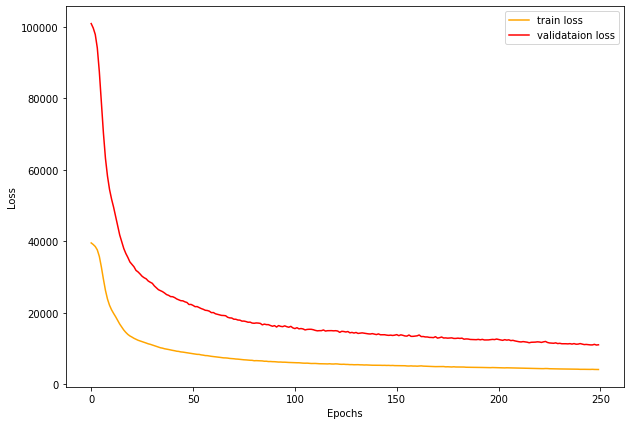

In [101]:
# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)

# Training & Evaluation

In [110]:
!mkdir new
for i in range(64):
  res=model.decode(torch.rand(16))
  save_image(res.cpu(), f"new/new{i}.jpg")

In [112]:
images = []
for path in Path('new').rglob('*.jpg'):
    images.append(mpimg.imread(path))


plt.figure(figsize=(200,200))
columns = 8
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')